In [1]:
from cavity import *

import ipywidgets as widgets
from ipywidgets import Layout, interact, FloatSlider

np.set_printoptions(precision=10)

%matplotlib inline

# Plot perturbation - Two mirrors and a lens

In [10]:
x_1 = 0.63752
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 6.6409000000e-01
# x_2 = -5.179474679231213e-07
y_2 = 0.0000000000e+00
t_2 = 0.0000000000e+00
p_2 = 0.0000000000e+00
r_2 = 5.6600000000e-03
w_2 = 1.0000000000e-03
n_in = 1.5000000000e+00
n_out = 1.0000000000e+00
x_3 = -1.0953903000e-02
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
r_3 = 5.0000000000e-03
axis_span = 0.005
camera_center = 2
lambda_laser = 1064e-9

elev=38.00
azim=168.00
axis_span=0.02
focus_point=2
dim=2

p_2 += np.pi
p_3 += np.pi

def f(print_parameters, element, parameter_index, shifts_max, shifts_n, shift_percentile_for_plotting, x_2, x_2_small_perturbation):
    x_2 += x_2_small_perturbation
    shifts_max = 10**shifts_max
    shifts_min = -shifts_max
    if print_parameters:
        print(f"{parameter_index=}\n{element=}\n{shifts_max=:.10e}\n{shifts_n=:.10e}\n{shift_percentile_for_plotting=:.10e}")
        
    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                   [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)    
    
    overlap_plot_shift_value = shifts_min * (1-shift_percentile_for_plotting) + shift_percentile_for_plotting * shifts_max
    shifts = np.linspace(shifts_min, shifts_max, int(shifts_n))
    overlaps, _ = cavity.calculated_shifted_cavity_overlap_integral((element, parameter_index), shifts)
    # print(np.stack([shifts, overlaps], axis=-1))
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    ax[0].plot(shifts, overlaps, label='overlap')
    ax[0].axvline(overlap_plot_shift_value, color='gray', linestyle='--', label='shift for gaussians overlap_plot')
    ax[0].legend()
    ax[0].set_xlabel("shift")
    ax[0].set_ylabel("overlap")
    ax[0].set_ylim(0.85, 1.01)
    ax[0].set_xlim(shifts_min, shifts_max)
    # tolerance = find_distance_to_first_crossing(shifts, overlaps)
    tolerance = cavity.calculate_parameter_critical_tolerance(parameter_index=(element, parameter_index),
                                                                                     initial_step=1e-6)
    ax[0].axvline(tolerance, linestyle='--', color='g')
    cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point, ax=ax[1])
    
    ax[1].set_title(
        f"NA short arm = {cavity.arms[2].mode_parameters.NA[1]:.4f} NA long arm = {cavity.arms[0].mode_parameters.NA[0]:.4f}")
    ax[1].set_ylim(-0.004, 0.004)
    ax[1].set_title(f"modes shape, NA of short arm = {cavity.arms[2].mode_parameters.NA[0]:.2e}")
    ax[1].set_xlim(x_3-0.001, x_1+0.001)
    perturbed_cavity = perturb_cavity(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value)
    try:
        spot_size_lines = perturbed_cavity.generate_spot_size_lines(dim=dim)
        for line in spot_size_lines:
            ax[1].plot(line[0, :], line[1, :], color='green', linestyle='--', alpha=0.8, linewidth=0.5)
    except FloatingPointError:
        print("kaki")
    plot_2_cavity_perturbation_overlap(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value, ax=ax[2], axis_span=cavity.arms[0].mode_parameters.w_0[0] * 3)
    ax[2].set_xlabel("z")
    ax[2].set_ylabel("y")
    ax[0].set_title(f"tolerance={tolerance:.2e}")

    
max_shift_boundary = 1e-1
shifts_max = 1e-8
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 parameter_index=widgets.Dropdown(value=0, options=[("x", 0), ('y', 1), ('t', 2), ('p', 3), ("r", 4), ("w", 5), ("n", 6)], description='parameter_index'),
                 element=widgets.Dropdown(options=[("Right Mirror", 0), ('Lens', 1), ('Left Mirror', 2)], value=0, description='parameter'),
                 shifts_max=FloatSlider(value=-5, min=-10, max=1, step=1e-9, description='shifts_max', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shifts_n=FloatSlider(value=10, min=1, max=1000, step=1, description='shifts_n', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shift_percentile_for_plotting=FloatSlider(value=0.5, min=0, max=1, step=0.0001, description='shift_percentile_for_plotting', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-1e-2, max=0, step=1e-9, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-1e-5, max=0, step=1e-9, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Dropdown(description='parameter',…

# Set ups exploration:

In [5]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, x_2_small_perturbation, y_2, t_2, p_2, r_2, w_2, n_out, n_in,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, camera_center,
      set_initial_surface, dim):
    

    
    if print_default_parameters:
        print(f"default_x_1 = {x_1+x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2+x_2_small_perturbation:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3+x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}\ndefault_n_out = {n_out}\ndefault_n_in = {n_in}")   
        
    axis_span = 10**axis_span

    if print_parameters:
        print(f"x_1={x_1+x_1_small_perturbation:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.10e}\nx_2={x_2+x_2_small_perturbation:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{r_2=:.10e}\n{w_2=:.10e}\n{n_in=:.10e}\n{n_out=:.10e}\nx_3={x_3+x_3_small_perturbation:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.10e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")
        
    x_1 += x_1_small_perturbation
    p_2 += np.pi
    x_3 += x_3_small_perturbation
    p_3 += np.pi
    x_2 += x_2_small_perturbation

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
   

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=camera_center)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)

    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
        f"NA long arm = {cavity.arms[0].mode_parameters.NA[0]:.4f} x_R long arm = {cavity.arms[0].mode_parameters.z_R[0]:.10e} \n NA short arm = {cavity.arms[2].mode_parameters.NA[1]:.4f} x_R short arm = {cavity.arms[2].mode_parameters.z_R[1]:.10e}\n x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / cavity.arms[2].mode_parameters.z_R[1]:.10e}")
    ax.set_ylim(-0.002, 0.002)
    # ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = 6.3752000000e-01
default_y_1 = 0.0000000000e+00
default_t_1 = 0.0000000000e+00
default_p_1 = 0.0000000000e+00
default_r_1 = 6.6409000000e-01
default_x_2 = 0.0000000000e+00
default_y_2 = 0.0000000000e+00
default_t_2 = 0.0000000000e+00
default_p_2 = 0.0000000000e+00
default_r_2 = 5.6600000000e-03
default_w_2 = 1.0000000000e-03
default_x_3 = -1.0953903000e-02
default_y_3 = 0.0000000000e+00
default_t_3 = 0.0000000000e+00
default_p_3 = 0.0000000000e+00
default_r_3 = 5.0000000000e-03
default_axis_span = 0.01
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1
default_n_out = 1.0
default_n_in = 1.5


widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=0, min=-1e-3, max=1e-3, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=default_r_1*0.8, max=default_r_1*1.3, step=1e-9, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=-1e-2, max=1e-2, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2_small_perturbation=FloatSlider(value=0, min=-1e-5, max=1e-5, step=1e-9, description='x_2_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=-1e-8, max=1e-8, step=1e-10, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=default_r_2*0.8, max=default_r_2*1.3, step=1e-10, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-1, max=r_max, step=1e-9, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=0, min=-2e-4, max=2e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=default_r_3*0.8, max=default_r_3*1.3, step=1e-9, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=-0.45, min=-5, max=5, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=False, description='set initial surface', disabled=False),
                 camera_center=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

In [2]:
# Near concentric two mirrors resonator:
x_1=3.400000e-01
x_1_b=6.5789500000e-04
x_1_c=0.0000000000e+00
y_1=0.0000000000e+00
t_1=0.0000000000e+00
p_1=0.0000000000e+00
r_1=2.0000000000e-01
x_3=-5.0000000000e-02
y_3=0.0000000000e+00
t_3=0.0000000000e+00
p_3=0.0000000000e+00
r_3=2.0000000000e-01
lambda_laser=10.6400e-07

x_1 += x_1_b
x_1 += x_1_c
p_3 += np.pi

params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                lambda_laser=lambda_laser)

def f(print_parameters, element, parameter_index, shifts_min, shifts_max, shifts_dx, shift_percentile_for_plotting, axis_span, elev, azim, x_axis_stretch, y_axis_stretch, z_axis_stretch, dim):
    if print_parameters:
        print(f"{parameter_index=}\n{element=}\n{shifts_min=:.10e}\n{shifts_max=:.10e}\n{shifts_dx=:.10e}\n{shift_percentile_for_plotting=:.10e}")
    overlap_plot_shift_value = shifts_min * (1-shift_percentile_for_plotting) + shift_percentile_for_plotting * shifts_max
    shifts = np.arange(shifts_min, shifts_max, shifts_dx)
    overlaps, _ = cavity.calculated_shifted_cavity_overlap_integral((element, parameter_index), shifts)
    
    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=-1)
    ax.set_xlim(ax.get_xlim()[0]*x_axis_stretch, ax.get_xlim()[1]*x_axis_stretch)
    ax.set_ylim(ax.get_ylim()[0]*y_axis_stretch, ax.get_ylim()[1]*y_axis_stretch)
    plt.title(
        f"NA unperturbed = {cavity.arms[0].mode_parameters.NA[0]:.4f}")
    # plt.ylim(-cavity.arms[0].mode_parameters.w_0[0] * 4 * axis_span, cavity.arms[0].mode_parameters.w_0[0] * 4 * axis_span)
    # plt.xlim(-0.15, 1)
    perturbed_cavity = perturb_cavity(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value)
    try:
        spot_size_lines = perturbed_cavity.generate_spot_size_lines(dim=dim)
        for line in spot_size_lines:
            if dim == 2:
                ax.plot(line[:, 0], line[:, 1], color='g', linestyle='--', alpha=0.8, linewidth=0.5)
            else:
                ax.plot(line[:, 0], line[:, 1], line[:, 2], color='g', linestyle='--', alpha=0.8, linewidth=0.5)
    except FloatingPointError:
        print("kaki")
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
        ax.set_zlim(ax.get_ylim()[0]*z_axis_stretch, ax.get_ylim()[1]*z_axis_stretch)
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))
    ax[0].plot(shifts, overlaps, label='overlap')
    ax[0].axvline(overlap_plot_shift_value, color='gray', linestyle='--', label='shift for gaussians overlap_plot')
    ax[0].legend()
    ax[0].set_xlabel("shift")
    ax[0].set_ylabel("overlap")
    plot_2_cavity_perturbation_overlap(cavity=cavity, parameter_index= (element, parameter_index), shift_value = overlap_plot_shift_value, ax=ax[1], axis_span=cavity.arms[0].mode_parameters.w_0[0] * 10)
    ax[1].set_xlabel("z")
    ax[1].set_ylabel("y")
    print(perturbed_cavity.mode_parameters[0].center)
    
 

    
shifts_min = -0.2
shifts_dx = -0.2
        
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 parameter_index=widgets.Dropdown(value=0, options=[("x", 0), ('y', 1), ('t', 2), ('p', 3), ("r", 4), ("w", 5), ("n", 6)], description='parameter_index'),
                 element=widgets.Dropdown(options=[("Right Mirror", 0), ('Left Mirror', 1)], value=0, description='parameter'),
                 shifts_min=FloatSlider(value=-1e-1, min=-1e-1, max=1e-1, step=1e-6, description='shifts_min', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shifts_max=FloatSlider(value=1e-1, min=-1e-1, max=1e-1, step=1e-6, description='shifts_max', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shifts_dx=FloatSlider(value=1e-3, min=1e-8, max=1e-2, step=1e-7, description='shifts_dx', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 shift_percentile_for_plotting=FloatSlider(value=0.5, min=0, max=1, step=0.0001, description='shift_percentile_for_plotting', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 axis_span=FloatSlider(value=1, min=0.01, max=2, step=0.01, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=38, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=168, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 x_axis_stretch=FloatSlider(value=1, min=0.01, max=10, step=0.01, description='x_axis_stretch', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 y_axis_stretch=FloatSlider(value=1, min=0.01, max=10, step=0.01, description='y_axis_stretch', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 z_axis_stretch=FloatSlider(value=1, min=0.01, max=10, step=0.01, description='z_axis_stretch', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 dim=widgets.Dropdown(options=[2, 3], value=2, description='Dimensions:'),
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Dropdown(description='parameter',…

In [3]:
def f(elev=44, azim=250):
    mirror = CurvedMirror(radius=1,
                          outwards_normal=np.array([1, 0, 0]),
                          origin=np.array([0, 0, 0]))
    y = np.array([-0.2, 0, 0.2])
    z = np.array([-0.2, 0, 0.2])
    Y, Z = np.meshgrid(y, z)
    X = np.zeros_like(Y)
    origin = np.stack([X, Y, Z], axis=-1)
    k_vector = np.array([1, 0, 0])
    ray = Ray(origin=origin, k_vector=k_vector)
    reflected_ray = mirror.reflect_ray(ray)
    mirror.plot()
    ax = plt.gca()
    ray.plot(ax)
    reflected_ray.plot(ax)
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    

widgets.interact(f, elev=(0, 180, 1), azim=(0, 360, 1));

interactive(children=(IntSlider(value=44, description='elev', max=180), IntSlider(value=250, description='azim…

In [6]:
def f(elev=44, azim=250):
    lens = IdealLens(focal_length=1,
                        outwards_normal=np.array([1, 0, 0]),
                        center=np.array([1, 0, 0]))
    y = np.array([-0.2, 0, 0.2])
    z = np.array([-0.2, 0, 0.2])
    Y, Z = np.meshgrid(y, z)
    X = np.zeros_like(Y)
    origin = np.stack([X, Y, Z], axis=-1)
    k_vector = np.array([1, 0, 0])
    ray = Ray(origin=origin, k_vector=k_vector)
    reflected_ray = lens.reflect_ray(ray)
    mirror.plot()
    ax = plt.gca()
    ray.plot(ax)
    reflected_ray.plot(ax)
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    

widgets.interact(f, elev=(0, 180, 1), azim=(0, 360, 1));

interactive(children=(IntSlider(value=44, description='elev', max=180), IntSlider(value=250, description='azim…

In [3]:
def f(print_parameters,
      x_1=0, y_1=0, t_1 = 0, p_1 = 0,
      x_2=0, y_2=0, t_2 = 0, p_2 = 0,
      x_3=0, y_3=0, t_3 = 0, p_3 = 0,
      t_ray=0, theta_ray=0, p_ray=0, phi_ray=0,
      elev=38, azim=192, axis_span=0, focus_point=-1,
     set_initial_surface=True, dim=2):
    
    if print_parameters:
        print(f"{x_1=:.2f}\n{y_1=:.2f}\n{t_1=:.2f}\n{p_1=:.2f}\n{x_2=:.2f}\n{y_2=:.2f}\n{t_2=:.2f}\n{p_2=:.2f}\n{x_3=:.2f}\n{y_3=:.2f}\n{t_3=:.2f}\n{p_3=:.2f}\n{t_ray=:.2f}\n{theta_ray=:.2f}\n{p_ray=:.2f}\n{phi_ray=:.2f}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")
    
    x_1 += 1
    y_1 += 0.00
    t_1 += 0
    p_1 += -np.pi / 6
    x_2 += 0
    y_2 += np.sqrt(3)
    t_2 += 0
    p_2 += np.pi / 2
    x_3 += -1
    y_3 += 0
    t_3 += 0
    p_3 += 7 * np.pi / 6

    normal_1 = unit_vector_of_angles(t_1, p_1)
    center_1 = np.array([x_1, y_1, 0])
    normal_2 = unit_vector_of_angles(t_2, p_2)
    center_2 = np.array([x_2, y_2, 0])
    normal_3 = unit_vector_of_angles(t_3, p_3)
    center_3 = np.array([x_3, y_3, 0])

    mirror_1 = FlatMirror(outwards_normal=normal_1, distance_from_origin=1)
    mirror_2 = FlatMirror(outwards_normal=normal_2, distance_from_origin=1)
    mirror_3 = FlatMirror(outwards_normal=normal_3, distance_from_origin=1)

    cavity = Cavity([mirror_1, mirror_2, mirror_3], set_initial_surface=set_initial_surface)
    
    central_line_parameters, success = cavity.find_central_line()
    central_line_parameters[0] = 0
    central_line_parameters[2] = 0
    
    initial_ray = cavity.ray_of_initial_parameters(central_line_parameters + np.array([t_ray, theta_ray, p_ray, phi_ray]))
    
    ray_history = cavity.trace_ray(initial_ray)
    
    # output_parameters = cavity.surfaces[-1].get_parameterization(ray_history[-1].origin)

    ax = cavity.plot(camera_center=focus_point, axis_span=axis_span, ray_list=ray_history, dim=dim)
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    plt.show()
    
    

x_min = -0.05
x_max = 0.05
r_min = -0.19
r_max = 0.19
dx = 0.0001
dt_max = 200
dtheta_max = 100

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 x_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 theta_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='theta_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 phi_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='phi_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 elev=FloatSlider(value=38, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=168, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=1, min=0.01, max=2, step=0.01, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 dim=widgets.Dropdown(options=[2, 3], value=2, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=True, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=-1, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), FloatSlider(value=0.0, descriptio…

In [6]:
def f(print_parameters=False,
    x_1=0, y_1=0, r_1=0, t_1 = 0, p_1 = 0,
      x_2=0, y_2=0, r_2=0, t_2 = 0, p_2 = 0,
      x_3=0, y_3=0, r_3=0, t_3 = 0, p_3 = 0, R=1.2,
      t_ray=0, theta_ray=0, p_ray=0, phi_ray=0, lambda_laser=0.01,
      elev=38, azim=192, axis_span=0, focus_point=-1,
     set_initial_surface=True, dim=2):
    
    if print_parameters:
        print(f"{x_1=:.2f}\n{y_1=:.2f}\n{r_1=:.2f}\n{t_1=:.2f}\n{p_1=:.2f}\n{x_2=:.2f}\n{y_2=:.2f}\n{r_2=:.2f}\n{t_2=:.2f}\n{p_2=:.2f}\n{x_3=:.2f}\n{y_3=:.2f}\n{r_3=:.2f}\n{t_3=:.2f}\n{p_3=:.2f}\n{t_ray=:.2f}\n{theta_ray=:.2f}\n{p_ray=:.2f}\n{phi_ray=:.2f}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")
    
    R+=1
    
    x_1 += 1
    y_1 += 0.00
    r_1 += R
    t_1 += 0
    p_1 += -np.pi / 6
    x_2 += 0
    y_2 += np.sqrt(3)
    r_2 += R
    t_2 += 0
    p_2 += np.pi / 2
    x_3 += -1
    y_3 += 0
    r_3 += R
    t_3 += 0
    p_3 += 7 * np.pi / 6
    
    
    normal_1 = unit_vector_of_angles(t_1, p_1)
    center_1 = np.array([x_1, y_1, 0])
    normal_2 = unit_vector_of_angles(t_2, p_2)
    center_2 = np.array([x_2, y_2, 0])
    normal_3 = unit_vector_of_angles(t_3, p_3)
    center_3 = np.array([x_3, y_3, 0])

    mirror_1 = CurvedMirror(radius=r_1, outwards_normal=normal_1, center=center_1)
    mirror_2 = CurvedMirror(radius=r_2, outwards_normal=normal_2, center=center_2)
    mirror_3 = CurvedMirror(radius=r_3, outwards_normal=normal_3, center=center_3)
    
    cavity = Cavity([mirror_1, mirror_2, mirror_3], set_initial_surface=set_initial_surface)
    
    central_line_parameters, success = cavity.find_central_line()
    cavity.set_mode_parameters()
    
    initial_ray_parameters = central_line_parameters + np.array([t_ray, theta_ray, p_ray, phi_ray])
    initial_ray = cavity.ray_of_initial_parameters(initial_ray_parameters)
    ray_history = cavity.trace_ray(initial_ray)

    ax = cavity.plot(camera_center=focus_point, axis_span=axis_span, ray_list=ray_history, dim=dim)
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    # else:
    #     ax.set_aspect(1)
    for ray in cavity.central_line:
        ray.plot(ax=ax, dim=dim, color='b', linewidth=0.5)
        
    
   
    

x_min = -0.05
x_max = 0.05
r_min = -0.19
r_max = 0.19
dx = 0.0001
dt_max = 200
dtheta_max = 100

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 x_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=0, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 R=FloatSlider(value=0.16, min=0.16, max=1, step=dx, description='R', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='t_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 theta_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='theta_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_ray=FloatSlider(value=0, min=x_min*10, max=x_max*10, step=dx, description='p_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 phi_ray=FloatSlider(value=0, min=x_min, max=x_max, step=dx, description='phi_ray', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=0.01, min=0.001, max=1, step=0.001, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=38, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=168, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=1, min=0.01, max=10, step=0.01, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 dim=widgets.Dropdown(options=[2, 3], value=2, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=True, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=-1, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), FloatSlider(value=0.0, descriptio…

# Alexey's dummy cavity

In [6]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, r_2,
      x_3, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point,
      set_initial_surface, dim):
    
    if print_parameters:
        print(f"{x_1=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.2f}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{r_2=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.2e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")
        
    if print_default_parameters:
        print(f"default_x_1 = {x_1=:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    y_1 += 0
    t_1 += 0
    p_1 += 0
    x_2 += 0
    y_2 += 0
    t_2 += 0
    p_2 += 5 * np.pi / 4
    x_3 += 0
    y_3 += 0
    t_3 += 0
    p_3 += np.pi / 2

    params = np.array([[x_1, y_1, 0, t_1, p_1, r_1],
                       [x_2, y_2, 0, t_2, p_2, r_2],
                       [x_3, y_3, 0, t_3, p_3, r_3]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True, lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()
    
    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"NA_out of plane = {cavity.arms[0].mode_parameters.NA[0]:.2e} , NA_in plane = {cavity.arms[0].mode_parameters.NA[1]:.2e}")
    
    for mirror in cavity.mirrors:
        ax.plot(mirror.origin[0], mirror.origin[1], 'ro')
    
    if print_mathematica_parameters:
        print(f"r_1={{{cavity.mirrors[0].origin[0]:.5f}, {cavity.mirrors[0].origin[1]:.5f}, 0}}\nR_1={cavity.mirrors[0].radius:.5f}\nr_2={{{cavity.mirrors[1].origin[0]:.5f}, {cavity.mirrors[1].origin[1]:.5f}, 0}}\nR_2={cavity.mirrors[1].radius:.5f}\nr_3={{{cavity.mirrors[2].origin[0]:.5f}, {cavity.mirrors[2].origin[1]:.5f}, 0}}\nR_3={cavity.mirrors[2].radius:.5f}")
    
    # plt.show()
    fig_2, ax_2 = plt.subplots(2, 1)
    shifts_r_1 = np.linspace(0, 0.02, 100)
    overlaps_r_1 = cavity.calculated_shifted_cavity_overlap_integral((0, 5), shifts_r_1)

    shifts_p_1 = np.linspace(0, 0.02, 100)
    overlaps_p_1 = cavity.calculated_shifted_cavity_overlap_integral((0, 4), shifts_p_1)

    ax_2[0].plot(shifts_r_1, overlaps_r_1, label="r_1 stability")
    ax_2[1].plot(shifts_p_1, overlaps_p_1, label="p_1 stability")
    ax_2[0].legend()
    ax_2[1].legend()
    # plt.show()
 
    
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = x_1=6.000e-01
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 4.000e-01
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_r_2 = 4.070e-01
default_x_3 = 0.000e+00
default_y_3 = 6.000e-01
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 4.000e-01
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.87
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=r_min, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=r_min, max=r_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Symmetric 2 mirrors and one lens - Low NA:

In [5]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      lambda_laser, elev, azim, axis_span, focus_point, set_initial_surface, dim, n_out, n_in,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, f_2, w_2,
      x_3, y_3, t_3, p_3, r_3,
      ):

    if print_parameters:
        print(f"{x_1=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.2f}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{f_2=:.10e}\n{w_2=:.10e}\n{n_in=:.10e}\n{n_out=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.2e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_f_2 = {f_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    x_1 += x_1_small_perturbation
    y_1 += 0
    t_1 += 0
    p_1 += 0
    x_2 += 0
    y_2 += 0
    t_2 += 0
    p_2 += np.pi
    x_3 += 0
    y_3 += 0
    t_3 += 0
    p_3 += np.pi
    r_2 = 2 * (n_in - n_out) * f_2

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    cavity.find_central_line()
    # central_line = cavity.trace_ray(cavity.default_initial_ray)
    # for i, arm in enumerate(cavity.arms):
        # arm.central_line = central_line[i]
    # cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)
    
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
            f"NA right arm = {cavity.arms[0].mode_parameters.NA[0]:.10e} x_R right arm = {cavity.arms[0].mode_parameters.z_R[0]:.10e} \n"
            f"NA left arm = {cavity.arms[2].mode_parameters.NA[1]:.10e} x_R left arm = {cavity.arms[2].mode_parameters.z_R[1]:.10e}\n"
            f"x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / cavity.arms[2].mode_parameters.z_R[1]:.10e}")    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = 1.000e-01
default_x_1_small_perturbation=0
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 7.000e-02
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_f_2 = 3.500e-02
default_w_2 = 1.000e-03
default_x_3 = -1.000e-01
default_y_3 = 0.000e+00
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 7.000e-02
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.13
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1
default_n_out=1
default_n_in=1.5

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=default_focus_point, description='Focus on mirror:',),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 f_2=FloatSlider(value=default_f_2, min=r_min, max=r_max, step=dx, description='f_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Symmetric 2 mirrors and one lens - High NA:

In [9]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, r_2, w_2, n_out, n_in,
      x_3, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point,
      set_initial_surface, dim):

    if print_parameters:
        print(f"{x_1=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.2f}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{r_2=:.10e}\n{w_2=:.10e}\n{n_in=:.10e}\n{n_out=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.2e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    x_1 += x_1_small_perturbation
    y_1 += 0
    t_1 += 0
    p_1 += 0
    x_2 += 0
    y_2 += 0
    t_2 += 0
    p_2 += np.pi
    x_3 += 0
    y_3 += 0
    t_3 += 0
    p_3 += np.pi

    mirror_1 = CurvedMirror.from_params(np.array([x_1, y_1, 0, t_1, p_1, r_1, 1, 0, 0, 0]))
    mirror_3 = CurvedMirror.from_params(np.array([x_3, y_3, 0, t_3, p_3, r_3, 1, 0, 0, 0]))
    lens_2_right, lens_2_left = generate_lens(radius=r_2,
                                              thickness=w_2,
                                              n_out=n_out,
                                              n_in=n_in,
                                              center=np.array([x_2, y_2, 0]),
                                              direction=unit_vector_of_angles(t_2, p_2))

    cavity = Cavity([mirror_1, lens_2_right, lens_2_left, mirror_3], set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    cavity.find_central_line()
    # central_line = cavity.trace_ray(cavity.default_initial_ray)
    # for i, arm in enumerate(cavity.arms):
        # arm.central_line = central_line[i]
    # cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)

    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
        f"NA_out of plane = {cavity.arms[0].mode_parameters.NA[0]:.2e} , NA_in plane = {cavity.arms[0].mode_parameters.NA[1]:.2e}")
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = 1.0161e-01
default_x_1_small_perturbation = 0
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 5.000e-02
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_r_2 = 1.100e-01
default_w_2 = 3.000e-03
default_n_out = 1
default_n_in = 1.5
default_x_3 = -1.200e-01
default_y_3 = 0.000e+00
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 5.000e-02
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.13
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=dx, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Calculated surface", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# not symmetric 2 mirrors and one lens - Low NA:

In [40]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      lambda_laser,
      elev, azim,
      set_initial_surface, dim,
      y_1, t_1, p_1,
      x_2, y_2, t_2, p_2, r_2, w_2, y_3, t_3, p_3, n_out, n_in, axis_span, focus_point,
      x_1, x_1_small_perturbation, r_1, x_3, x_3_small_perturbation, r_3):

    if print_parameters:
        print(f"{x_1=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.2f}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{r_2=:.10e}\n{w_2=:.10e}\n{n_in=:.10e}\n{n_out=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.2e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_x_1_small_perturbation = {default_x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_x_3_small_perturbation = {default_x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}")   
    x_1 += x_1_small_perturbation
    p_2 += np.pi
    x_3 += x_3_small_perturbation
    p_3 += np.pi

    mirror_1 = CurvedMirror.from_params(np.array([x_1, y_1, 0, t_1, p_1, r_1, 1, 0, 0, 0]))
    mirror_3 = CurvedMirror.from_params(np.array([x_3, y_3, 0, t_3, p_3, r_3, 1, 0, 0, 0]))
    lens_2_right, lens_2_left = generate_lens(radius=r_2,
                                              thickness=w_2,
                                              n_out=n_out,
                                              n_in=n_in,
                                              center=np.array([x_2, y_2, 0]),
                                              direction=unit_vector_of_angles(t_2, p_2))

    cavity = Cavity([mirror_1, lens_2_right, lens_2_left, mirror_3], set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)

    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
        f"NA short arm = {cavity.arms[0].mode_parameters.NA[0]:.4f}\n NA long arm = {cavity.arms[2].mode_parameters.NA[1]:.4f}")
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

default_x_1 = 8.176e-01
default_x_1_small_perturbation = 0.000e+00
default_y_1 = 0.000e+00
default_t_1 = 0.000e+00
default_p_1 = 0.000e+00
default_r_1 = 7.342e-01
default_x_2 = 0.000e+00
default_y_2 = 0.000e+00
default_t_2 = 0.000e+00
default_p_2 = 0.000e+00
default_r_2 = 1.100e-01
default_w_2 = 3.000e-03
default_x_3 = -2.11050e-1
default_x_3_small_perturbation = -4.857e-4
default_y_3 = 0.000e+00
default_t_3 = 0.000e+00
default_p_3 = 0.000e+00
default_r_3 = 5.000e-02
default_lambda_laser = 10.64e-07
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_focus_point = 3

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=default_x_3_small_perturbation, min=-5e-4, max=5e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );

interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# not-symmetric two cavities and a lens - smart choice of parameters:

In [16]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters, print_parameters_matrix,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, r_2, w_2, n_out, n_in,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point, dim):

    if print_parameters:
        print(f"x_1={x_1+x_1_small_perturbation:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.10e}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\n{r_2=:.10e}\n{w_2=:.10e}\n{n_in=:.10e}\n{n_out=:.10e}\nx_3={x_3+x_3_small_perturbation:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.10e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{dim=}")

    if print_default_parameters:
        print(f"default_x_1 = {x_1+x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_r_2 = {r_2:.10e}\ndefault_w_2 = {w_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_x_3_small_perturbation = {default_x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_focus_point = {focus_point}\ndefault_n_out = {n_out}\ndefault_n_in = {n_in}")   
        
    x_1 += x_1_small_perturbation
    p_2 += np.pi
    x_3 += x_3_small_perturbation
    p_3 += np.pi
    
    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
    if print_parameters_matrix:
        print(f"{params=}")

    cavity = Cavity.from_params(params=params, standing_wave=True,
                    lambda_laser=lambda_laser)
    # cavity.find_central_line()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    ax.set_ylim(-0.005, 0.005)
    ax.set_title(
        f"NA long arm = {np.nan_to_num(cavity.arms[0].mode_parameters.NA[0], nan=0):.4f} x_R long arm = {np.nan_to_num(cavity.arms[0].mode_parameters.z_R[0], nan=0):.10e}\n"
        f"NA short arm = {np.nan_to_num(cavity.arms[2].mode_parameters.NA[1], nan=0):.4f} x_R short arm = {np.nan_to_num(cavity.arms[2].mode_parameters.z_R[1], nan=0):.10e}\n")
    plt.show()



x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.00001
dt_max = 200
dtheta_max = 100

NA_2 = 10e-2
NA_1 = 1e-3
L_2 = 0.01
λ = 1064e-9
n = 1.5
d = 0.001

x_R2 = λ / (np.pi * NA_2**2)
R_3 = L_2 / 2 + x_R2**2 / (L_2 / 2)
R_22 = R_3
w_22 = NA_2 * x_R2 * np.sqrt(1+(L_2 / (2*x_R2))**2)
w_21 = w_22
x_R1 = λ / (np.pi * NA_1**2)
w_01 = λ / (np.pi * NA_1)
L_1 = 2*x_R1 * np.sqrt((w_21 / w_01)**2 - 1)
R_21 = L_1 / 2 + 2*x_R1**2 / L_1
R_1 = R_21
f_2 = R_21 * R_22 / (R_21 + R_22)
R_2 = f_2 * (n-1) * (1+np.sqrt(1+ d / (f_2*n)))



default_x_1 = L_1 + d / 2
default_x_1_small_perturbation = 0.000000e+00
default_y_1 = 0.000000e+00
default_t_1 = 0.000000e+00
default_p_1 = 0.000000e+00
default_r_1 = R_1
default_x_2 = 0.000000e+00
default_y_2 = 0.000000e+00
default_t_2 = 0.000000e+00
default_p_2 = 0.000000e+00
default_r_2 = R_2
default_w_2 = d
default_x_3 = - L_2 - d/ 2
default_x_3_small_perturbation = -4.857000e-04
default_y_3 = 0.000000e+00
default_t_3 = 0.000000e+00
default_p_3 = 0.000000e+00
default_r_3 = R_3
default_lambda_laser = λ
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_focus_point = 3
default_n_out = 1
default_n_in = 1.5

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 print_parameters_matrix=widgets.Checkbox(value=False, description='print_parameters_matrix', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.8e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-5e-4, max=5e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.8e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_2=FloatSlider(value=default_r_2, min=r_min, max=r_max, step=dx, description='r_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 w_2=FloatSlider(value=default_w_2, min=r_min, max=r_max, step=dx, description='w_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_out=FloatSlider(value=default_n_out, min=1, max=2, step=dx, description='n_out', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 n_in=FloatSlider(value=default_n_in, min=1, max=2, step=dx, description='n_in', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=default_x_3_small_perturbation, min=-5e-4, max=5e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=dx, max=0.01, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=1, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );







interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# not-symmetric two cavities and an ideal lens - smart choice of parameters:

In [ ]:
def f(print_parameters, print_mathematica_parameters, print_default_parameters,
      x_1, x_1_small_perturbation, y_1, t_1, p_1, r_1,
      x_2, y_2, t_2, p_2, f_2,
      x_3, x_3_small_perturbation, y_3, t_3, p_3, r_3,
      lambda_laser,
      elev, azim, axis_span, focus_point,
      set_initial_surface, dim):

    if print_parameters:
        print(f"{x_1=:.10e}\n{x_1_small_perturbation=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.2f}\n{x_2=:.10e}\n{y_2=:.10e}\n{t_2=:.10e}\n{p_2=:.10e}\nf_2 = {f_2:.10e}\n{x_3=:.10e}\n{x_3_small_perturbation=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{r_3=:.10e}\n{lambda_laser=:.2e}\n{elev=:.2f}\n{azim=:.2f}\n{axis_span=:.2f}\n{focus_point=}\n{set_initial_surface=}\n{dim=}")

    if print_default_parameters:
        print(f"default_x_1 = {x_1:.10e}\ndefault_x_1_small_perturbation = {default_x_1_small_perturbation:.10e}\ndefault_y_1 = {y_1:.10e}\ndefault_t_1 = {t_1:.10e}\ndefault_p_1 = {p_1:.10e}\ndefault_r_1 = {r_1:.10e}\ndefault_x_2 = {x_2:.10e}\ndefault_y_2 = {y_2:.10e}\ndefault_t_2 = {t_2:.10e}\ndefault_p_2 = {p_2:.10e}\ndefault_f_2 = {f_2:.10e}\ndefault_x_3 = {x_3:.10e}\ndefault_x_3_small_perturbation = {default_x_3_small_perturbation:.10e}\ndefault_y_3 = {y_3:.10e}\ndefault_t_3 = {t_3:.10e}\ndefault_p_3 = {p_3:.10e}\ndefault_r_3 = {r_3:.10e}\ndefault_lambda_laser = {lambda_laser:.2e}\ndefault_elev = {elev:.2f}\ndefault_azim = {azim:.2f}\ndefault_axis_span = {axis_span:.2f}\ndefault_dim = {dim}\ndefault_set_initial_surface = {set_initial_surface}\ndefault_focus_point = {focus_point}\ndefault_f_2={f_2:.10e}")   
    x_1 += x_1_small_perturbation
    p_2 += np.pi
    x_3 += x_3_small_perturbation
    p_3 += np.pi

    mirror_1 = CurvedMirror.from_params(np.array([x_1, y_1, 0, t_1, p_1, r_1, 1, 0, 0, 0]))
    mirror_3 = CurvedMirror.from_params(np.array([x_3, y_3, 0, t_3, p_3, r_3, 1, 0, 0, 0]))
    ideal_lens = IdealLens(outwards_normal=unit_vector_of_angles(t_2, p_2), center=np.array([x_2, y_2, 0]), focal_length=f_2)

    cavity = Cavity([mirror_1, ideal_lens, mirror_3], set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    # ax.set_xlim(- axis_span, axis_span)
    # ax.set_ylim(-0.0025, 0.0025)

    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    ax.set_title(
    f"NA right arm = {cavity.arms[0].mode_parameters.NA[0]:.10e} x_R right arm = {cavity.arms[0].mode_parameters.z_R[0]:.10e} \n"
    f"NA left arm = {cavity.arms[2].mode_parameters.NA[1]:.10e} x_R left arm = {cavity.arms[2].mode_parameters.z_R[1]:.10e}\n"
    f"x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / cavity.arms[2].mode_parameters.z_R[1]:.10e}")
    ax.set_xlim(1.2*x_3, -2*x_3)
    ax.set_ylim(-0.015, 0.015)
    

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.000001
dt_max = 200
dtheta_max = 100

NA_2 = 5e-02
NA_1 = 5e-03
L_2 = 0.01
λ = 1064e-9

x_R2 = λ / (np.pi * NA_2**2)
R_3 = L_2 / 2 + x_R2**2 / (L_2 / 2)
R_22 = R_3
w_22 = NA_2 * x_R2 * np.sqrt(1+(L_2 / (2*x_R2))**2)
w_21 = w_22
x_R1 = λ / (np.pi * NA_1**2)
w_01 = λ / (np.pi * NA_1)
L_1 = 2*x_R1 * np.sqrt((w_21 / w_01)**2 - 1)
R_21 = L_1 / 2 + 2*x_R1**2 / L_1
R_1 = R_21
f_2 = R_21 * R_22 / (R_21 + R_22)

default_x_1 = L_1
default_x_1_small_perturbation = 0.000000e+00
default_y_1 = 0.000000e+00
default_t_1 = 0.000000e+00
default_p_1 = 0.000000e+00
default_r_1 = R_1
default_x_2 = 0.000000e+00
default_y_2 = 0.000000e+00
default_t_2 = 0.000000e+00
default_p_2 = 0.000000e+00
default_f_2 = f_2
default_x_3 = - L_2
default_x_3_small_perturbation = -4.857000e-04
default_y_3 = 0.000000e+00
default_t_3 = 0.000000e+00
default_p_3 = 0.000000e+00
default_r_3 = R_3
default_lambda_laser = λ
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.00
default_dim = 2
default_set_initial_surface = False
default_focus_point = 3
widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=default_x_1-0.1, max=default_x_1+0.1, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.8e', layout=Layout(width='2000px')),
                 x_1_small_perturbation=FloatSlider(value=default_x_1_small_perturbation, min=-1e-4, max=1e-4, step=1e-9, description='x_1_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=default_r_1-0.1, max=default_r_1+0.1, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_2=FloatSlider(value=default_x_2, min=r_min, max=r_max, step=dx, description='x_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_2=FloatSlider(value=default_y_2, min=x_min, max=x_max, step=dx, description='y_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_2=FloatSlider(value=default_t_2, min=x_min, max=x_max, step=dx, description='t_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_2=FloatSlider(value=default_p_2, min=x_min, max=x_max, step=dx, description='p_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 f_2=FloatSlider(value=default_f_2, min=default_f_2-0.1, max=default_f_2+0.1, step=dx, description='f_2', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=default_x_3-0.1, max=default_x_3+0.1, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 x_3_small_perturbation=FloatSlider(value=default_x_3_small_perturbation, min=-dx, max=5e-4, step=1e-9, description='x_3_small_perturbation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_3=FloatSlider(value=default_r_3, min=default_r_3-0.1, max=default_r_3+0.1, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );







interactive(children=(Checkbox(value=False, description='print_parameters'), Checkbox(value=False, description…

# Two mirros cavity

In [ ]:
def f(print_parameters,
      x_1, x_1_b, x_1_c, y_1, t_1, p_1, r_1, r_1_b, r_1_c,
      x_3, y_3, t_3, p_3,
      lambda_laser, axis_span, focus_point, dim):
    
    
    if print_parameters:
        print(f"{x_1=:.10e}\n{x_1_b=:.10e}\n{x_1_c=:.10e}\n{y_1=:.10e}\n{t_1=:.10e}\n{p_1=:.10e}\n{r_1=:.10e}\n{x_3=:.10e}\n{y_3=:.10e}\n{t_3=:.10e}\n{p_3=:.10e}\n{lambda_laser=:.10e}")
    x_1 += x_1_b
    x_1 += x_1_c
    r_1 += r_1_b
    r_1 += r_1_c
    r_3 = r_1
    p_3 += np.pi

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])

    cavity = Cavity.from_params(params=params, set_initial_surface=False, standing_wave=True,
                    lambda_laser=lambda_laser)
    # cavity.find_central_line()
    central_line = cavity.trace_ray(cavity.default_initial_ray)
    for i, arm in enumerate(cavity.arms):
        arm.central_line = central_line[i]
    cavity.central_line_successfully_traced = True
    cavity.set_mode_parameters()

    ax = cavity.plot(dim=dim, axis_span=axis_span, camera_center=focus_point)
    if dim == 3:
        ax.view_init(elev=elev, azim=azim)
    L = (x_1 - x_3)
    g_1 = 1 - L / r_1
    g_2 = 1 - L / r_3
    theoretical_x_R = np.sqrt(g_1 * g_2 * (1-g_1 * g_2) / (g_1 + g_2 - 2 * g_1 * g_2)**2) * L
    theoretical_x_R_2 = L / 2 * np.sqrt(2 * r_1 / L - 1)
    # print(theoretical_x_R_2)
    theoretical_NA = np.sqrt(lambda_laser / (np.pi * theoretical_x_R))
    ax.set_title(
        f"NA = {cavity.arms[0].mode_parameters.NA[0]:.4f} x_R = {cavity.arms[0].mode_parameters.z_R[0]:.10e}\n NA theoretical = {theoretical_NA:.4f} x_R theoretical = {theoretical_x_R}\n x_Rs ratio={cavity.arms[0].mode_parameters.z_R[1] / theoretical_x_R:.10e}")

x_min = -0.05
x_max = 0.05
r_min = 0
r_max = 1
dx = 0.000001
dt_max = 200
dtheta_max = 100

λ = 1064e-9



default_x_1 = 0.05
default_x_1_b = 0.000000e+00
default_y_1 = 0.000000e+00
default_t_1 = 0.000000e+00
default_p_1 = 0.000000e+00
default_r_1 = 0.2
default_x_3 = - 0.05
default_y_3 = 0.000000e+00
default_t_3 = 0.000000e+00
default_p_3 = 0.000000e+00
default_r_3 = 0.2
default_lambda_laser = λ
default_elev = 38.00
default_azim = 168.00
default_axis_span = 0.5
default_dim = 2
default_set_initial_surface = False
default_focus_point = -1

widgets.interact(f,
                 print_parameters=widgets.Checkbox(value=False, description='print_parameters', disabled=False),
                 print_mathematica_parameters=widgets.Checkbox(value=False, description='print_mathematica_parameters', disabled=False),
                 print_default_parameters=widgets.Checkbox(value=False, description='print_default_parameters', disabled=False),
                 x_1=FloatSlider(value=default_x_1, min=-r_max, max=r_max, step=dx, description='x_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_b=FloatSlider(value=default_x_1_b, min=-1e-2, max=1e-2, step=1e-9, description='x_1_b', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_1_c=FloatSlider(value=default_x_1_b, min=-1e-4, max=1e-4, step=1e-9, description='x_1_c', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 y_1=FloatSlider(value=default_y_1, min=x_min, max=x_max, step=dx, description='y_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_1=FloatSlider(value=default_t_1, min=x_min, max=x_max, step=dx, description='t_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_1=FloatSlider(value=default_p_1, min=x_min, max=x_max, step=dx, description='p_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1=FloatSlider(value=default_r_1, min=r_min, max=r_max, step=dx, description='r_1', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1_b=FloatSlider(value=0, min=-1e-3, max=1e-3, step=1e-6, description='r_1_b', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 r_1_c=FloatSlider(value=0, min=-1e-6, max=1e-6, step=1e-9, description='r_1_c', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 x_3=FloatSlider(value=default_x_3, min=-r_max, max=r_max, step=1e-5, description='x_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.5e', layout=Layout(width='2000px')),
                 y_3=FloatSlider(value=default_y_3, min=r_min, max=r_max, step=dx, description='y_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 t_3=FloatSlider(value=default_t_3, min=x_min, max=x_max, step=dx, description='t_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 p_3=FloatSlider(value=default_p_3, min=x_min, max=x_max, step=dx, description='p_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 # r_3=FloatSlider(value=default_r_3, min=r_min, max=r_max, step=dx, description='r_3', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 lambda_laser=FloatSlider(value=default_lambda_laser, min=500e-9, max=1100e-9, step=1e-9, description='lambda laser', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 elev=FloatSlider(value=default_elev, min=0, max=90, step=1, description='elevation', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 azim=FloatSlider(value=default_azim, min=0, max=360, step=1, description='azimuth', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='500px')),
                 axis_span=FloatSlider(value=default_axis_span, min=0.001, max=2, step=0.001, description='axis span', disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.3e', layout=Layout(width='2000px')),
                 dim=widgets.Dropdown(options=[2, 3], value=default_dim, description='Dimensions:'),
                 set_initial_surface=widgets.Checkbox(value=default_set_initial_surface, description='set initial surface', disabled=False),
                 focus_point=widgets.Dropdown(options=[("Middle of cavity", -1), ('First', 0), ('Second', 1), ('Third', 2), ("Fourth", 3)], value=default_focus_point, description='Focus on mirror:',)
                 );







interactive(children=(Checkbox(value=False, description='print_parameters'), FloatSlider(value=0.05, descripti…

# Specific setups:

In [9]:
# High NA, two mirrors and one thick lens - the RIGHT mirror is tuned:
x_1=7.9700000000e-02
x_1_small_perturbation=-4.8890300000e-04
y_1=0.0000000000e+00
t_1=0.0000000000e+00
p_1=0.0000000000e+00
r_1=5.0470000000e-02
x_2=0.0000000000e+00
y_2=0.0000000000e+00
t_2=0.0000000000e+00
p_2=0.0000000000e+00
r_2=4.7100000000e-03
w_2=1.0000000000e-03
n_in=1.5000000000e+00
n_out=1.0000000000e+00
x_3=-1.0500000000e-02
x_3_small_perturbation=-4.8570000000e-04
y_3=0.0000000000e+00
t_3=0.0000000000e+00
p_3=0.0000000000e+00
r_3=5.0000000000e-03
lambda_laser=10.6400e-07
names = ['Right Mirror', 'lens', 'Left Mirror']

x_1 += x_1_small_perturbation
p_2 += np.pi
x_3 += x_3_small_perturbation
p_3 += np.pi



params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                   [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3, 5, endpoint=True)))
x_1_values = x_1 * ratios
cavity = Cavity.from_params(params=params, standing_wave=True,
                            lambda_laser=lambda_laser, names=names)


# High NA, two mirrors and one thick lens - the LEFT mirror is tuned:
x_1 = 5.8192000000e-01
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 5.3141000000e-01
x_2 = 0.0000000000e+00
y_2 = 0.0000000000e+00
t_2 = 0.0000000000e+00
p_2 = 0.0000000000e+00
r_2 = 5.1100000000e-03
w_2 = 1.0000000000e-03
n_in = 1.5000000000e+00
n_out = 1.0000000000e+00
x_3 = -1.0985700000e-02
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
r_3 = 5.0000000000e-03

p_2 += np.pi
p_3 += np.pi

# High NA ratio set-up:

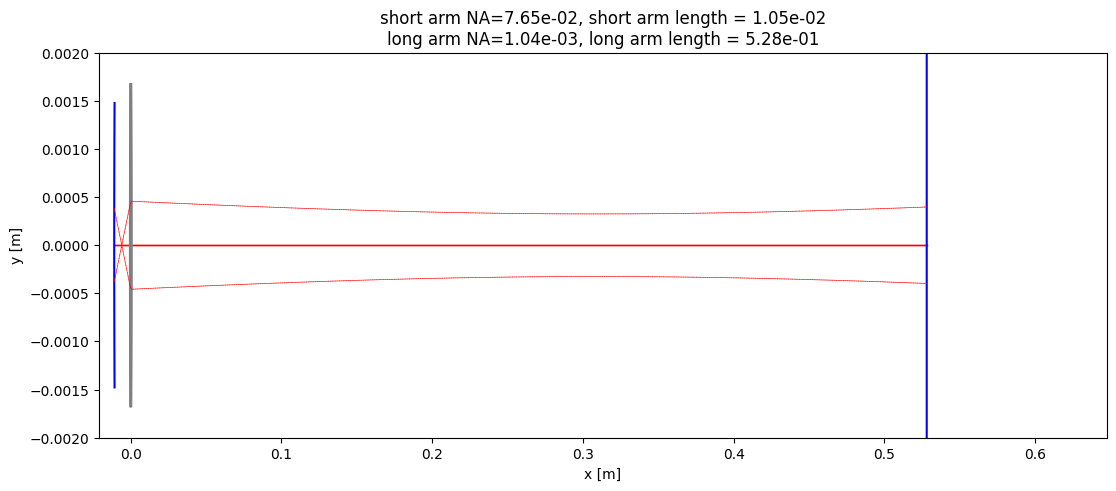

0
0
   0
23
23
   1
25
25
   2
26


C:\Users\michaeka\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


26
   3
26
26
   4
37
34
   5
9
9
1
   0
22
7
   1
24
20
   2


C:\Users\michaeka\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


37
37
   3
37
37
   4
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\michaeka\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\michaeka\AppData\Local\Temp\ipykernel_18832\105302004.py", line 52, in <module>
    NAs, tolerance_matrix, cavities = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(0, 0),
  File "C:\Users\michaeka\OneDrive - weizmann.ac.il\Current Semester\Research\cavity-design\cavity.py", line 1560, in generate_tolerance_of_NA
    cavities.append(cavity)
  File "C:\Users\michaeka\OneDrive - weizmann.ac.il\Current Semester\Research\cavity-design\cavity.py", line 1454, in generate_tolerance_threshold_matrix
    initial_step=initial_step,
  File "C:\Users\michaeka\OneDrive - weizmann.ac.il\Current Semester\Research\cavity-design\cavity.py", line 1440, in calculate_parameter_critical_tolerance
    crossing_value=overlap_threshold, accuracy=accuracy)
  F

In [10]:
# HIGH NA ratio - diverging to the right:



# HIGH NA - converging to the right:

x_1 = 0.63752
y_1 = 0.0000000000e+00
t_1 = 0.0000000000e+00
p_1 = 0.0000000000e+00
r_1 = 6.6409000000e-01
x_2 = 0.0000000000e+00
y_2 = 0.0000000000e+00
t_2 = 0.0000000000e+00
p_2 = 0.0000000000e+00
r_2 = 5.6600000000e-03
w_2 = 1.0000000000e-03
n_in = 1.5000000000e+00
n_out = 1.0000000000e+00
x_3 = -1.0953903000e-02
y_3 = 0.0000000000e+00
t_3 = 0.0000000000e+00
p_3 = 0.0000000000e+00
r_3 = 5.0000000000e-03
axis_span = 0.005
camera_center = 2
lambda_laser = 1064e-9
names = ['Right Mirror', 'lens', 'Left Mirror']

p_2 += np.pi
p_3 += np.pi

params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                   [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                   [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
# ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3, 5, endpoint=True)))
# x_1_values = x_1 * ratios
x_1_values = np.linspace(x_1, 0.2, 5)
params_temp = params.copy()
params_temp[0, 0] = x_1_values[1]
cavity = Cavity.from_params(params=params_temp, standing_wave=True,
                            lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)
fig, ax = plt.subplots(figsize=(13, 5))
cavity.plot(axis_span=0.05, camera_center=camera_center, ax=ax)
ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
ax.set_ylim(-0.002, 0.002)
ax.set_title(
    f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e}\n"
    f"long arm NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}")
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.savefig('figures/systems/mirror-lens-mirror_high_NA_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
# %%
NAs, tolerance_matrix, cavities = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(0, 0),
                                                           arm_index_for_NA=2, parameter_values=x_1_values,
                                                           t_is_trivial=True, p_is_trivial=True,
                                                           return_cavities=True, lambda_laser=lambda_laser)
# %%
for i in range(len(x_1_values)):
    overlaps_series = cavities[i].generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :, i]),
                                                          shift_size=100,
                                                          print_progress=True)
    cavities[i].generate_overlaps_graphs(overlap_threshold=0.9, arm_index_for_NA=2,
                                         overlaps_series=overlaps_series,
                                         tolerance_matrix=tolerance_matrix[:, :, i], names=names)
    plt.suptitle(
        f"short arm NA={cavities[i].arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavities[i].surfaces[2].center - cavities[i].surfaces[3].center):.2e}\n"
        f"long arm NA={cavities[i].arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavities[i].surfaces[1].center - cavities[i].surfaces[0].center):.2e}")
    plt.savefig(
        f'figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_overlaps_NA={cavities[i].arms[2].mode_parameters.NA[0]:.2e}.png',
        dpi=300, bbox_inches='tight')
    plt.show()
# %%
ax = plot_tolerance_of_NA_same_plot(NAs=NAs, tolerance_matrix=tolerance_matrix, names=names)
ax.legend(loc='upper right')
plt.savefig('figures/NA tolerance/mirror-lens-mirror_high_NA_ratio_tolerances_log.png', dpi=300,
            bbox_inches='tight')
plt.show()

In [9]:
    x_1 = 1.0000000000e-02
    y_1 = 0.0000000000e+00
    t_1 = 0.0000000000e+00
    p_1 = 0.0000000000e+00
    r_1 = 5.00001e-03
    x_3 = 0
    y_3 = 0.0000000000e+00
    t_3 = 0.0000000000e+00
    p_3 = 0.0000000000e+00
    lambda_laser = 1064e-09
    r_3 = r_1
    p_3 += np.pi
    dim = 2
    camera_center = -1
    names = ['Right Mirror', 'Left Mirror']

    params = np.array([[x_1, y_1, t_1, p_1, r_1, 0, 0, 0, 0, 1, 0],
                       # [x_2, y_2, t_2, p_2, r_2, n_in, w_2, n_out, 0, 0, 1],
                       [x_3, y_3, t_3, p_3, r_3, 0, 0, 0, 0, 1, 0]])
    ratios = 1 - np.concatenate((np.array([0]), np.logspace(-7, -3, 5, endpoint=True)))
    x_1_values = x_1 * ratios

    cavity = Cavity.from_params(params=params, standing_wave=True,
                                lambda_laser=lambda_laser, names=names, t_is_trivial=True, p_is_trivial=True)

    ax = cavity.plot(axis_span=1, camera_center=camera_center)
    ax.set_xlim(x_3 - 0.01, x_1 + 0.01)
    ax.set_ylim(-0.003, 0.003)
    ax.set_title(
        f"NA={cavity.arms[0].mode_parameters.NA[0]:.2e}, length = {np.linalg.norm(cavity.surfaces[1].center - cavity.surfaces[0].center):.2e}")
    # f"short arm NA={cavity.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity.surfaces[2].center - cavity.surfaces[3].center):.2e}\n"

    plt.savefig('figures/systems/Fabry-Perot.png', dpi=300, bbox_inches='tight')
    plt.show()
    # %%
    NAs, tolerance_matrix, cavities = generate_tolerance_of_NA(params, parameter_index_for_NA_control=(0, 0),
                                                               arm_index_for_NA=0, parameter_values=x_1_values,
                                                               t_is_trivial=True, p_is_trivial=True,
                                                               return_cavities=True)
    # %%
    for i in range(len(x_1_values)):
        overlaps_series = cavities[i].generate_overlap_series(shifts=2 * np.abs(tolerance_matrix[:, :, i]),
                                                              shift_size=100,
                                                              print_progress=True)
        cavities[i].generate_overlaps_graphs(overlap_threshold=0.9, arm_index_for_NA=0,
                                             overlaps_series=overlaps_series,
                                             tolerance_matrix=tolerance_matrix[:, :, i], names=names)
        plt.suptitle(
            f"long arm NA={cavities[i].arms[0].mode_parameters.NA[0]:.2e}, long arm length = {np.linalg.norm(cavities[i].surfaces[1].center - cavities[i].surfaces[0].center):.2e}"
            # f"short arm NA={cavity_temp.arms[2].mode_parameters.NA[0]:.2e}, short arm length = {np.linalg.norm(cavity_temp.surfaces[2].center - cavity_temp.surfaces[3].center):.2e}\n"
            )
        plt.savefig(f'figures/NA tolerance/Fabry-Perot_overlaps_NA={cavities[i].arms[0].mode_parameters.NA[0]:.2e}.png',
                    dpi=300, bbox_inches='tight')
        plt.show()
    # %%
    ax = plot_tolerance_of_NA_same_plot(NAs=NAs, tolerance_matrix=tolerance_matrix, names=names)
    plt.savefig('figures/NA tolerance/Fabry-Perot_tolerances.png', dpi=300, bbox_inches='tight')
    plt.show()